In [3]:
import os
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
tsp_data_txt = open('tsp_dataset.txt')

In [5]:
lines = tsp_data_txt.readlines()

In [6]:
tsp_data_txt = open('tsp_dataset.txt')
data = {}
lines = tsp_data_txt.readlines()
distance_matrix = np.zeros((len(lines),len(lines)))
for i,line in enumerate(lines):
    for j,element in enumerate((line.split('\n')[0].split('       '))):
        if(element == ''):
            continue
        
        distance_matrix[i][j-1] = int(element.strip())
data['distance_matrix']= distance_matrix
data['reward_matrix'] = [1 for i  in range(0,len(distance_matrix))]
data['depot'] = 0
data['n_state'] = len(distance_matrix)*len(distance_matrix)
data['n_action'] = len(distance_matrix)
data['visited_nodes'] = [0]


In [7]:
for i in range(0,len(data['distance_matrix'])):
    data['distance_matrix'][i][i] = 9999
    

In [8]:
def initialze_value(env):
    initial_P = 1/(env['n_action']-1)
    env['P'] = {}
    
    #P[state][action] = [(prob, next state, reward, done), ...]
    
    for i in range(0,env['n_state']):
        env['P'][i] ={}
        for j in range(0,env['n_action']):
            env['P'][i][j] = []
            for k in range(0,env['n_action']):
                ini_temp = [initial_P,k,data['reward_matrix'][k],False]
                env['P'][i][j].append(ini_temp)
            
    return env
    

In [9]:
def change_reward(envp):
    for i in range(0,envp['n_action']):
        for j in range(0,envp['n_action']):
            for k in range(0,envp['n_action']):
                if k==0:
                    env['P'][i][j][k][2]= -9999
                    env['P'][i][j][k][3]= True
                    break
    return envp

In [10]:
env = initialze_value(data)

In [11]:
Pi = np.random.uniform(size=(env['n_state'],env['n_action']))
Pi = Pi/np.sum(Pi,axis=1,keepdims=True)

In [12]:
def policy_evaluation(env,Pi,gamma=0.99,epsilon=1e-6):
    
    
    # Extract environment information
    n_state = env['n_state']
    P = env['P']
    # Random initial value function 
    V = np.random.uniform(size=(n_state,1))
    # Loop
    tick,V_dists,V_list = 0,[],[]
    while True:
        tick = tick + 1
        V_prime = np.zeros((n_state,))
        
        rm_s_lst = []
        for s in env['P'].keys(): # for all state
            rm_a_lst = []
            for a in env['P'][s].keys(): # for all actions
                for prob,s_prime,reward,done in env['P'][s][a]: 
                    if(s in rm_s_lst and a in rm_a_list):
                        prob*=0.00001
                        reward*=-100
                    else:
                        prob*=10
                        reward*=10
                    
                    V_prime[s] += (reward*(1/env['distance_matrix'][s//15][a])+gamma*V[s_prime]*(1/env['distance_matrix'][s//15][a]))*prob*Pi[s][a]
                if a not in rm_a_lst:
                    rm_a_lst.append(a)
        if s not in rm_s_lst:
            rm_s_lst.append(s)
            
        
        V_dist = np.max(np.abs(V-V_prime))
        V_dists.append(V_dist)
        V = V_prime
        V_list.append(V)
        if V_dist < epsilon:
            break
        if(tick==100):
            break
    return V,V_dists,V_list

In [13]:
V,V_dists,V_list = policy_evaluation(env,Pi,gamma=0.99,epsilon=1e-6)

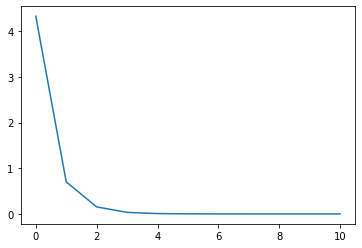

In [14]:
plt.plot(V_dists)

In [15]:
def policy_improvement(env,
                       V,
                       gamma=0.99):
    """
    Policy Improvement
    """
    n_state = env['n_state']
    act_space = env['n_action']
    n_action =  env['n_action']
    P = env['P']
    Q = np.zeros((n_state,n_action))
    # Loop
    for s in P.keys(): # for all states
        visited_lst = []
        for a in P[s].keys(): # for all actions
            for prob,s_prime,reward,done in P[s][a]:
                if a in visited_lst:
                    prob*=0.0001
                    reward*=0.0001
                Q[s,a] += (reward*(1/env['distance_matrix'][s//15][a]) + gamma*V[s_prime]*(1/env['distance_matrix'][s//15][a]))*prob
                
                tmp_Pi=np.zeros((n_state,n_action))
                tmp_Pi[np.arange(env['n_state']),np.argmax(Q,axis=1)] = 1
                for p in tmp_Pi:
                    a =np.where(p==1)[0][0]
                    if a not in visited_lst:
                        visited_lst.append(a)
            if(len(visited_lst)==15):
                visited_lst=[]
                
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
    return Pi

In [16]:
def policy_iteration(env,gamma=0.99,epsilon=1e-6):
    """
    Policy Iteration
    """
    n_state = env['n_state']
    act_space = env['n_action']
    n_action =  env['n_action']
    
    Pi = np.random.uniform(size=(n_state,n_action))
    Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
    
    while True:
        V,V_dists,V_list = policy_evaluation(env,Pi,gamma=gamma,epsilon=epsilon)
        Pi_prime = policy_improvement(env,V,gamma=gamma) 
        
        if (Pi == Pi_prime).all(): # if the policy does not change
            break
        Pi = Pi_prime
    return Pi,V

In [17]:
Pi,V = policy_iteration(env)

In [18]:
# Initialize environment
ret = 0
env['visited_nodes'] =[0]
for tick in range(100):
    obs = np.random.choice(env['n_state'],1)[0]
    action =np.where(Pi[obs][:]==1)[0][0]
    while action in env['visited_nodes']:
        obs = np.random.choice(env['n_state'],1)[0] # select action
        action =np.where(Pi[obs][:]==1)[0][0]
        if action not in env['visited_nodes']:
            break
        
    print("\n tick:[{}]".format(tick))
    print(env['visited_nodes'])
    env['visited_nodes'].append(action)
    #if(len(env['visited_nodes'])==14):
    #    env =change_reward(env)
    #next_obs,reward,done,info = env.step(action)
    #obs = next_obs
    #ret = reward + gamma*ret 
    if len(env['visited_nodes']) >14:
        break


 tick:[0]
[0]

 tick:[1]
[0, 13]

 tick:[2]
[0, 13, 3]

 tick:[3]
[0, 13, 3, 6]

 tick:[4]
[0, 13, 3, 6, 8]

 tick:[5]
[0, 13, 3, 6, 8, 1]

 tick:[6]
[0, 13, 3, 6, 8, 1, 9]

 tick:[7]
[0, 13, 3, 6, 8, 1, 9, 7]

 tick:[8]
[0, 13, 3, 6, 8, 1, 9, 7, 11]

 tick:[9]
[0, 13, 3, 6, 8, 1, 9, 7, 11, 14]

 tick:[10]
[0, 13, 3, 6, 8, 1, 9, 7, 11, 14, 2]

 tick:[11]
[0, 13, 3, 6, 8, 1, 9, 7, 11, 14, 2, 5]

 tick:[12]
[0, 13, 3, 6, 8, 1, 9, 7, 11, 14, 2, 5, 12]

 tick:[13]
[0, 13, 3, 6, 8, 1, 9, 7, 11, 14, 2, 5, 12, 4]


In [19]:
def visualize_map_route(data,tour_list=None):
    scaled_distance_matrix = data['distance_matrix']/100
    x_point = []
    y_point = []
    for di,dis in enumerate(scaled_distance_matrix[0]):
        if di%2 ==0 :
            x_point.append(dis-di*0.05*dis)
            y_point.append(di*0.01*dis)
        elif di%3==0:
            x_point.append(dis/2)
            y_point.append(dis/2)
        else:
            x_point.append(di*0.05*dis)
            y_point.append(dis-di*0.05*dis)
            
    plt.plot(x_point,y_point,'bo')
    plt.plot(x_point[0],y_point[0],'bo',color='red')
    line_x = []
    line_y = []
    if tour_list!=None:
        for tl in tour_list:
            line_x.append(x_point[tl])
            line_y.append(y_point[tl])
            
        plt.plot(line_x,line_y)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15148/3929654237.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_point[0],y_point[0],'bo',color='red')


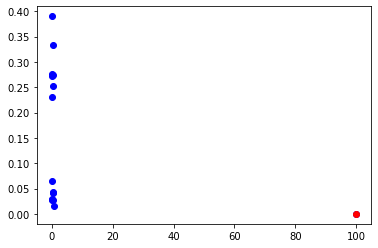

In [22]:
visualize_map_route(data,[0, 13, 3, 6, 8, 1, 9, 7, 11, 14, 2, 5, 12, 4,0])

In [26]:
def get_reward(visit_list):
        depot =0
        distance = (data['distance_matrix'])[0][visit_list[0]]
        prev_cite = visit_list[0]
        for i in range(1,14):
            distance+= (data['distance_matrix'])[prev_cite][visit_list[i]]
            prev_cite =visit_list[i]
        return distance

In [27]:
get_reward([13, 3, 6, 8, 1, 9, 7, 11, 14, 2, 5, 12, 4,0])

638.0